# Patterns in Performance: Clustering High School Student Math Course Data

**Names**: Aleksandra Grigortsuk, Wendy Zheng, Yinglei Wu, Xiangrui Deng

## 1. Introduction



Citations:



## 2. Dataset Discussion

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from gower import gower_matrix

from scipy.spatial.distance import pdist, squareform
warnings.filterwarnings('ignore')

c:\Users\grigo\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\grigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\grigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\grigo\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
df = pd.read_csv('movehub_data_cleaned.csv')
df.head(5)

,City,Country,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating
0,Lausanne,Switzerland,3.15,12.59,8.40,1.32,1714.00,4266.11,87.21,90.77,65.85,87.62,73.21,35.55
1,Geneva,Switzerland,2.80,12.94,10.49,1.28,2607.95,3917.72,83.27,61.22,74.88,29.43,82.76,54.36
2,Basel,Switzerland,3.50,11.89,7.35,1.25,1649.29,3847.76,84.20,78.17,79.74,59.18,88.27,28.12
3,Perth,Australia,2.87,11.43,10.08,0.97,2083.14,3358.55,95.38,62.11,80.56,23.53,74.62,50.01
4,Nashville,United States,3.84,12.00,13.50,0.65,2257.14,3089.75,80.61,80.30,60.30,0.00,80.50,25.50


In [25]:
df.shape

(185, 14)

The original dataset was downloaded from : https://www.kaggle.com/datasets/blitzr/movehub-city-rankings?select=movehubqualityoflife.csv and is extracted from movehub.com. (Date: 12/1/2023)
The dataset then was merged from the three datasets from Kaggle, which are: city, cost of living, and quality of life. The dataset contains 185 rows and 14 columns. The columns are: City, Country, Cappucino, Cinema, Wine, Gasoline, Avg Rent, Avg Disposable, Income, Movehub Rating, Purchase Power, Health Care, Pollution, Quality of Life, and Crime Rating. From the movehub website, they collect the data by combining the information from http://www.numbeo.com/, the CIA World Factbook, the World Health Organization, census from several governments, and their own database of real international moves. This dataset includes many different features, however, variables such as price of water, price of bread, and some other variables are not included in the dataset. Also, the dataset can also include avg temperature and avg humidity of the cities. [*todo* - add connection with the research goal and variables intend to use]

## 3. Dataset Cleaning and Exploration

### Missing Values Results 
1. As is indicated in the answer above, there are no missing values in this particular dataset. 

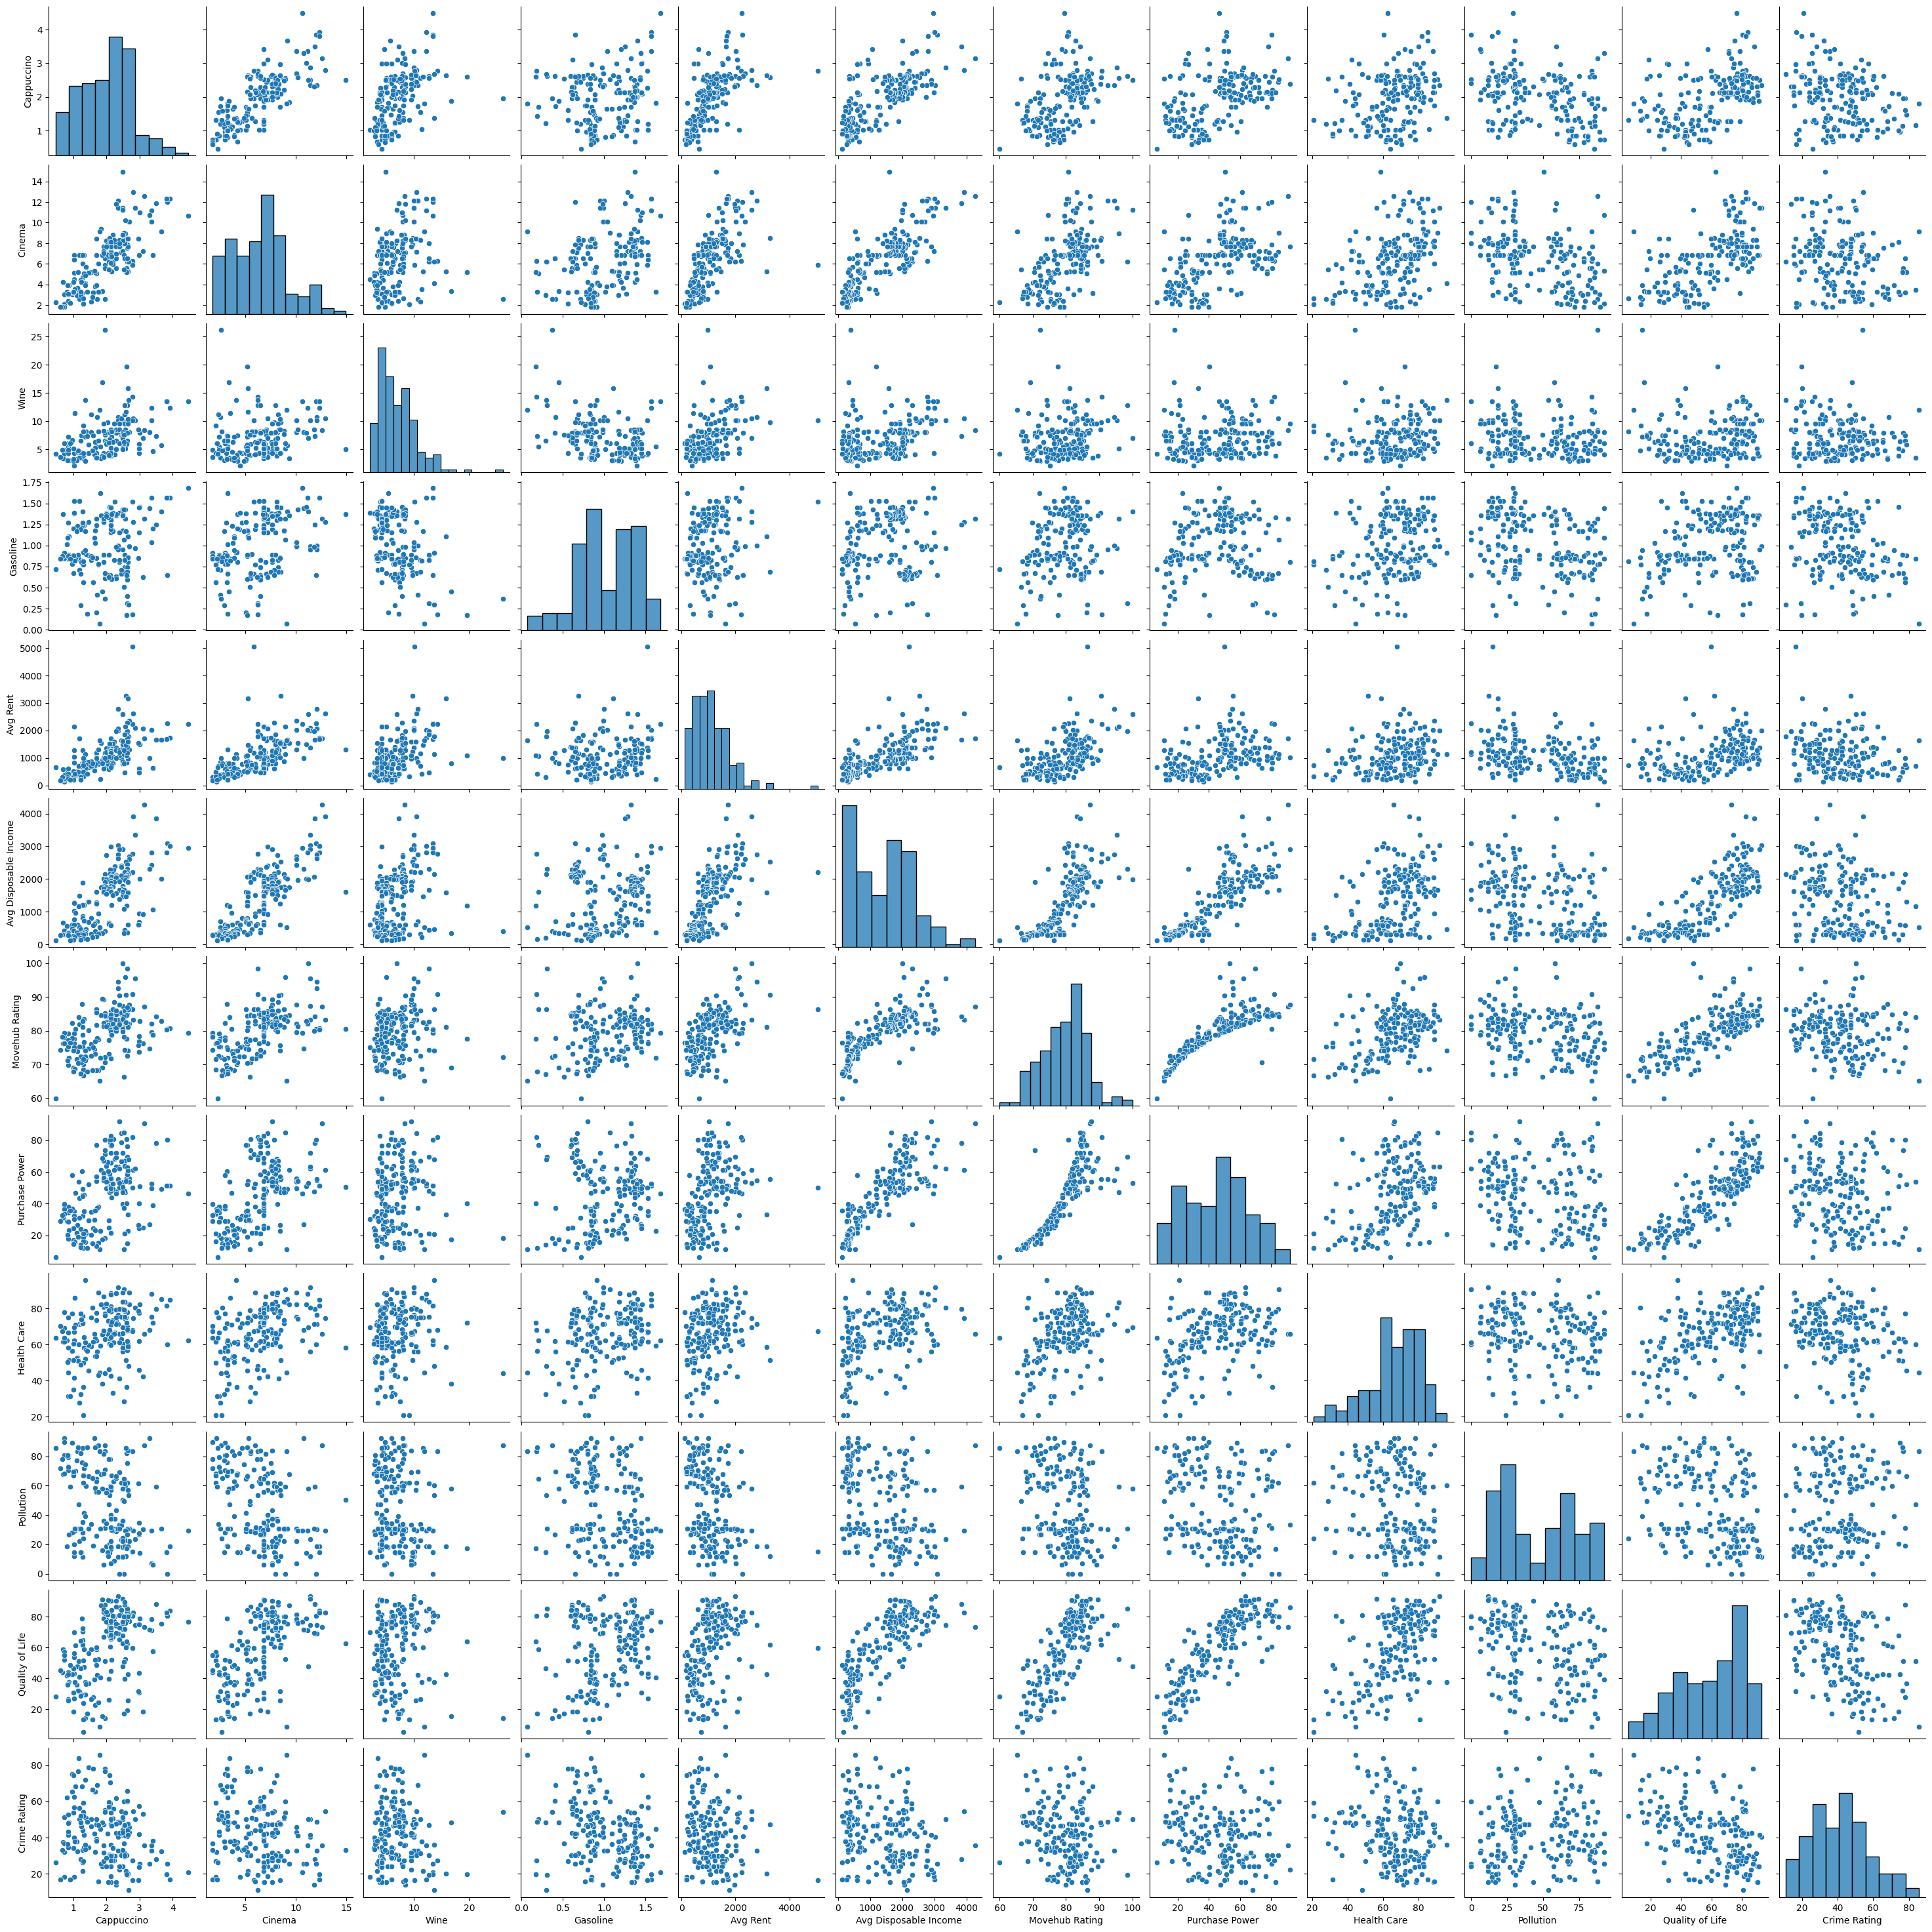

In [4]:
# Now, we would like to create a pair plot on all the numerical variables
df_numerical = df.iloc[:, 2:]
sns.pairplot(data=df_numerical)

### Pairwise Scatterplot Results
1. The majority of the variables in this dataset are numerical variables. Based on the pairwise scatterplots, there is one clear outlier with a large distance from the main cluster in the plots containing wine and avg rent variables. 

### Dendrograms for Outlier Detection

Next, we would like to detect high-dimensional outliers with single-linkage dendrograms. The single-linkage dendrogram algorithm is more likely to detect outliers than the average-linkage or complete-linkage algorithms.


In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

dm = pdist(df_numerical, metric='euclidean')
Z = linkage(dm, method='single')

fig, ax = plt.subplots(figsize=(25, 125))
d = dendrogram(Z, orientation='right', labels=df['City'].array, ax=ax)
ax.set_xlabel('Dissimilarity', fontsize=18)
ax.set_ylabel('Category', fontsize=18)
plt.yticks(fontsize=12)
plt.show()

KeyboardInterrupt: 

### Outlier Identification with Single-Linkage Dendrogram Results

Hong Kong is an obvious outlier in this dataset, so we will consider removing it from our analysis.

#### Explanation

Because our research goal is to cluster different cities based on city information, the outlier might bias the interpretation of some predictors on the final clustering results. The pros of dropping them is that we can draw general conclusions from the dataset which meets our research goals. However, the cons are that the final clustering algorithms might not be robust as they do not take into account marginal cases.

### Noise Detection
We will first remove the aforementioned outliers and detect noises for the rest of the dataset.

Then, to check for data noises, we plot the k=2, ..., k=9 distance plot

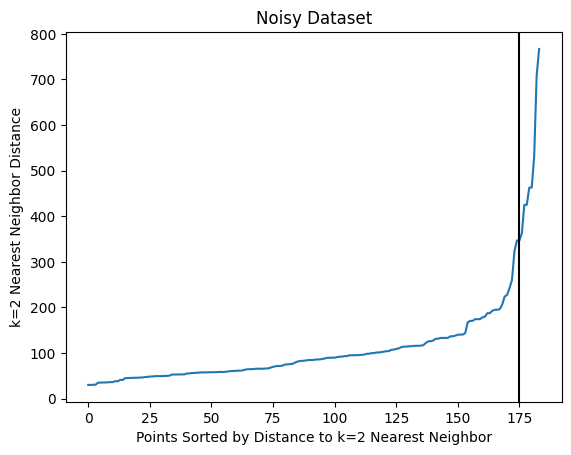

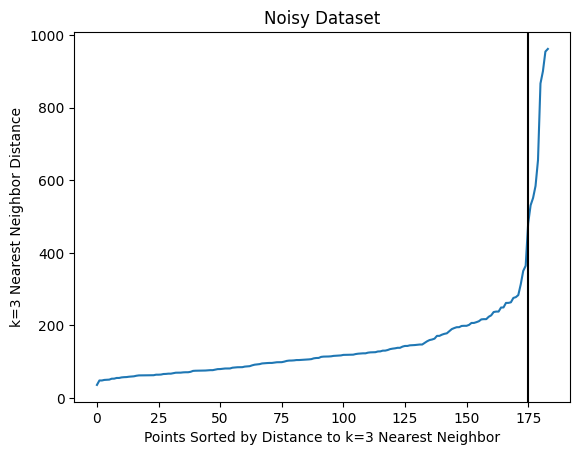

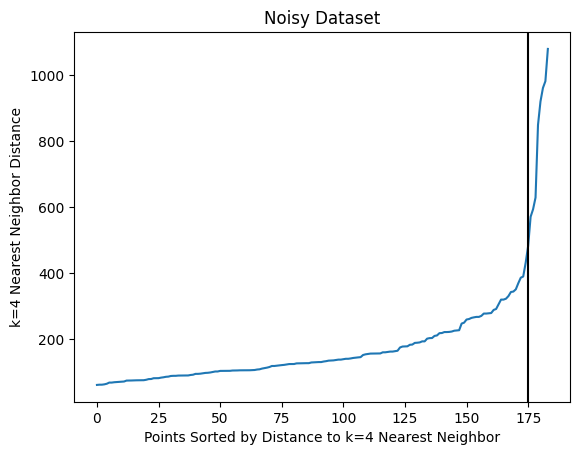

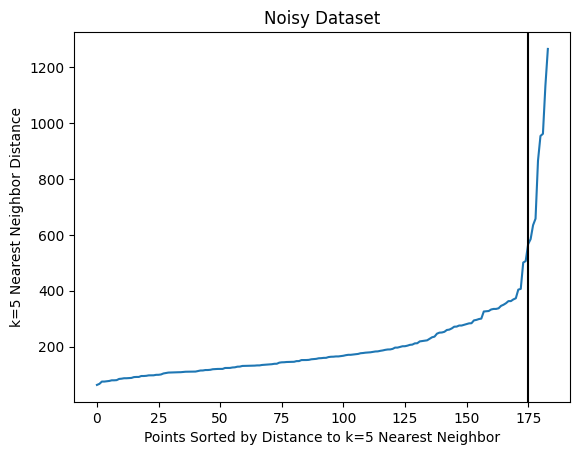

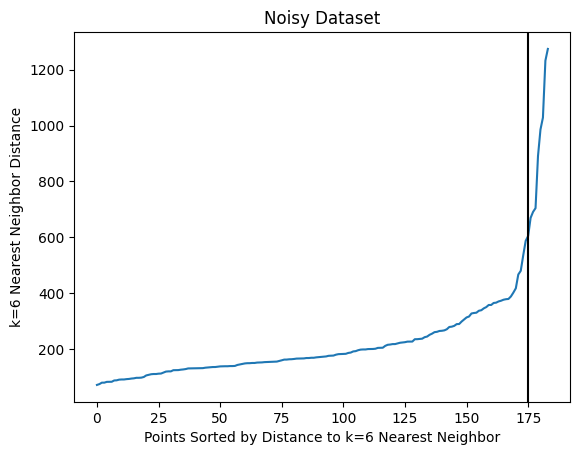

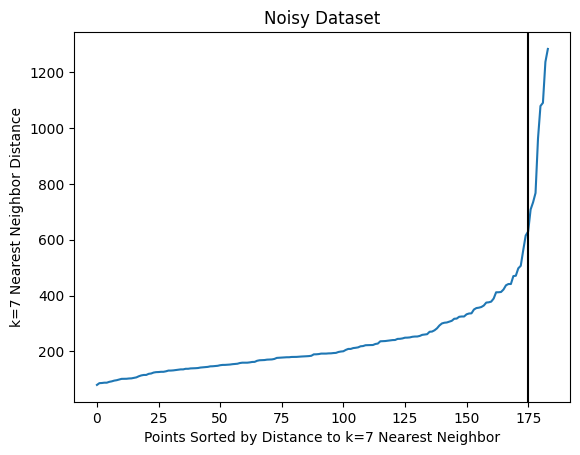

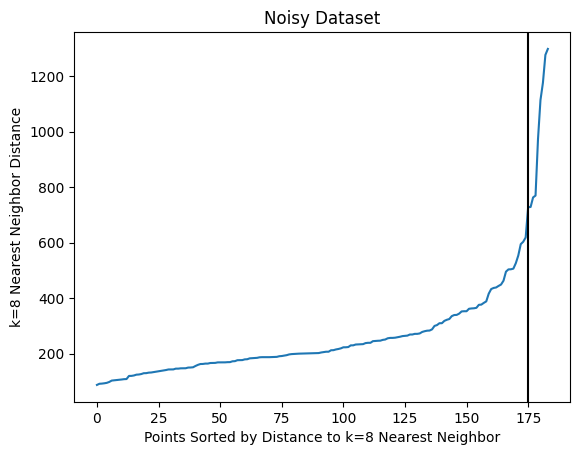

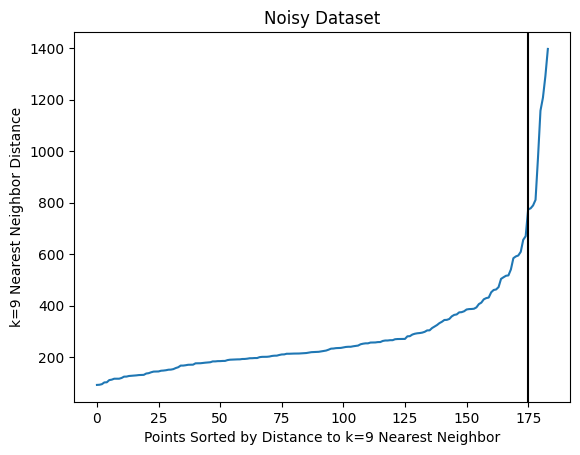

In [6]:
# Filter df
df_subset_outlier_removal = df[~df['City'].isin(['Hong Kong'])]

X_numerical = df_subset_outlier_removal.iloc[:, 2:]


from sklearn.neighbors import NearestNeighbors
#Find the distance of the kth nearest neighbor
for k in range(2,10):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X_numerical)
    distances, indices = nbrs.kneighbors(X_numerical)

    plt.plot(np.sort(distances.T[k-1]))
    plt.axvline(x=175, color='black')
    plt.xlabel('Points Sorted by Distance to k=%s Nearest Neighbor'%k)
    plt.ylabel('k=%s Nearest Neighbor Distance'%k)
    plt.title('Noisy Dataset')
    plt.show()

In [7]:
df_subset_outlier_removal.shape

(184, 14)

### Noisy Data Conclusion

For k=2...k=9 nearest neighbor plots, there is a dramatic jump in nearest neighbor distances when the number of observations is 175, which indicates that 9 noisy data points exist in the current dataset. Based on the information of noisy data obtained, we can pick reasonable values of $\epsilon$ when using DBSCAN algorithms for clustering. 

* In the k=2-5 nearest neighbors plot, we see that the closest neighbor of the 9 "noise points" is a distance of at least $\epsilon\approx 500$ away. Thus, if we were to set $minpts=2$, then we would want to set this $\epsilon\leq  500$.
* In the k=6-9 nearest neighbors plot, we see that the closest neighbor of the 9 "noise points" is a distance of at least $\epsilon\approx 700$ away. Thus, if we were to set $minpts=4$, then we would want to set this $\epsilon\leq  700$. Setting this value less than $\epsilon\leq  700$ could create even more noise points and/or more clusters in the dataset.

## 4. Basic Descriptive Analytics

In [8]:
#seperate numerical data 
df_num = df_subset_outlier_removal.select_dtypes(include = ['float64', 'int64'])

#summary of the numerical data
df_num.describe()

,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,1.973859,6.464457,7.024076,1.011087,1078.585217,1389.369348,79.575380,45.555326,65.983315,46.073533,59.036304,41.750652
std,0.762018,2.743758,3.380149,0.348088,611.958976,911.863618,6.657968,20.428574,14.983337,25.937334,22.214216,16.214349
min,0.460000,1.810000,2.130000,0.070000,120.680000,120.680000,59.880000,6.380000,20.830000,0.000000,5.290000,10.860000
25%,1.310000,4.237500,4.260000,0.780000,614.947500,513.577500,74.992500,28.815000,58.880000,23.897500,42.437500,29.702500
50%,2.085000,6.820000,6.335000,0.985000,980.650000,1493.255000,80.645000,47.775000,67.635000,38.185000,63.335000,41.420000
75%,2.490000,7.970000,8.317500,1.322500,1412.445000,2045.960000,84.020000,60.407500,77.295000,68.252500,78.175000,51.097500
max,4.480000,14.950000,26.150000,1.680000,3268.840000,4266.110000,100.000000,91.850000,95.960000,92.420000,93.050000,85.700000


In [10]:
#seperate the categorical data
df_cat = df_subset_outlier_removal.select_dtypes(include = ['object'])
print(df_cat.head())

#summary of the categorical data
df_cat.describe()

        City        Country
0   Lausanne    Switzerland
1     Geneva    Switzerland
2      Basel    Switzerland
3      Perth      Australia
4  Nashville  United States


,City,Country
count,184,184
unique,184,78
top,Lausanne,United States
freq,1,19


[('Cappuccino', 'Cinema'),
 ('Cappuccino', 'Avg Rent'),
 ('Cappuccino', 'Avg Disposable Income'),
 ('Cinema', 'Cappuccino'),
 ('Cinema', 'Avg Rent'),
 ('Cinema', 'Avg Disposable Income'),
 ('Cinema', 'Movehub Rating'),
 ('Cinema', 'Purchase Power'),
 ('Cinema', 'Quality of Life'),
 ('Avg Rent', 'Cappuccino'),
 ('Avg Rent', 'Cinema'),
 ('Avg Rent', 'Avg Disposable Income'),
 ('Avg Rent', 'Movehub Rating'),
 ('Avg Disposable Income', 'Cappuccino'),
 ('Avg Disposable Income', 'Cinema'),
 ('Avg Disposable Income', 'Avg Rent'),
 ('Avg Disposable Income', 'Movehub Rating'),
 ('Avg Disposable Income', 'Purchase Power'),
 ('Avg Disposable Income', 'Quality of Life'),
 ('Movehub Rating', 'Cinema'),
 ('Movehub Rating', 'Avg Rent'),
 ('Movehub Rating', 'Avg Disposable Income'),
 ('Movehub Rating', 'Purchase Power'),
 ('Movehub Rating', 'Quality of Life'),
 ('Purchase Power', 'Cinema'),
 ('Purchase Power', 'Avg Disposable Income'),
 ('Purchase Power', 'Movehub Rating'),
 ('Purchase Power', 'Qualit

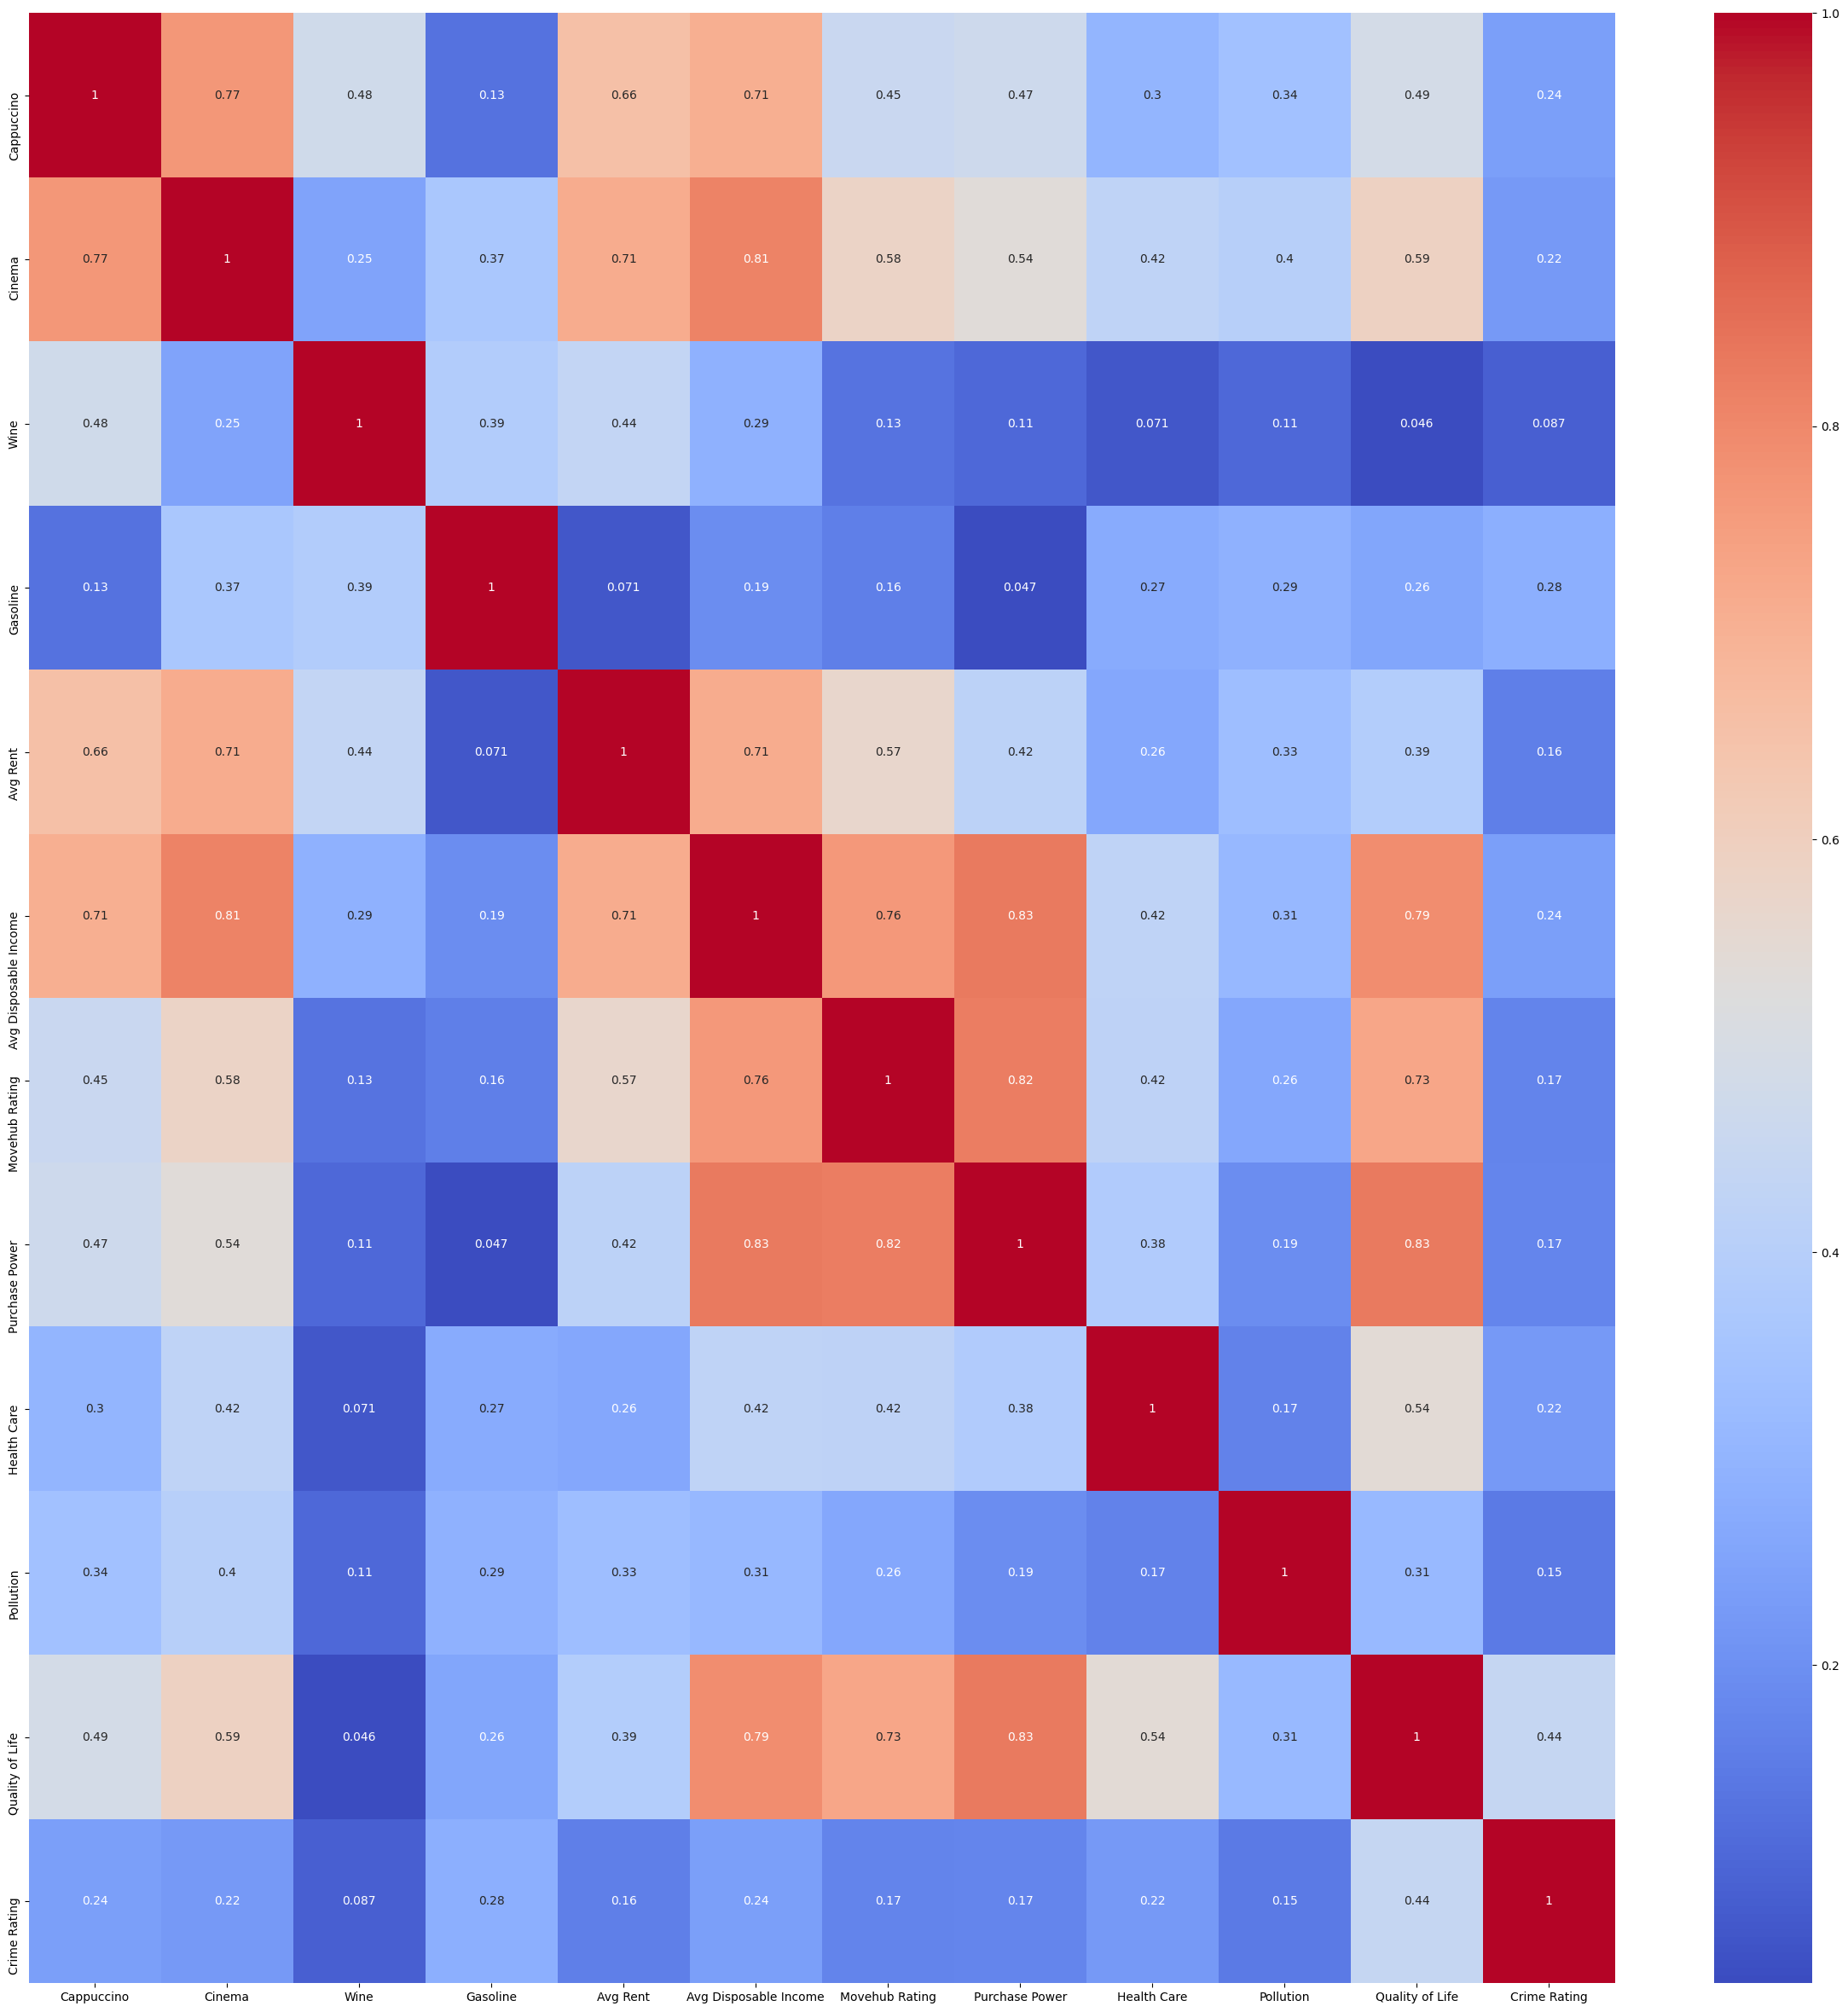

In [11]:
#pairwise correlation of numerical data
df_num_corr = df_num.corr()
df_num_corr

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_num_corr), annot = True, cmap = 'coolwarm')

high_corr_pairs = [(column, correlated_column) 
                   for column in df_num_corr.columns 
                   for correlated_column in  df_num_corr.columns 
                   if (abs(df_num_corr.loc[column, correlated_column]) > 0.5) and (column != correlated_column)]

high_corr_pairs


There's a lot of correlation within this dataset for example, Avg Disposable Income is highly correlated with Quality of Life, Purchase Power, Movehub Rating, Avg Rent, and Cinema and Cappuccino price. Purchase power is highly correlated with Movehub Rating, and so on.

<Axes: >

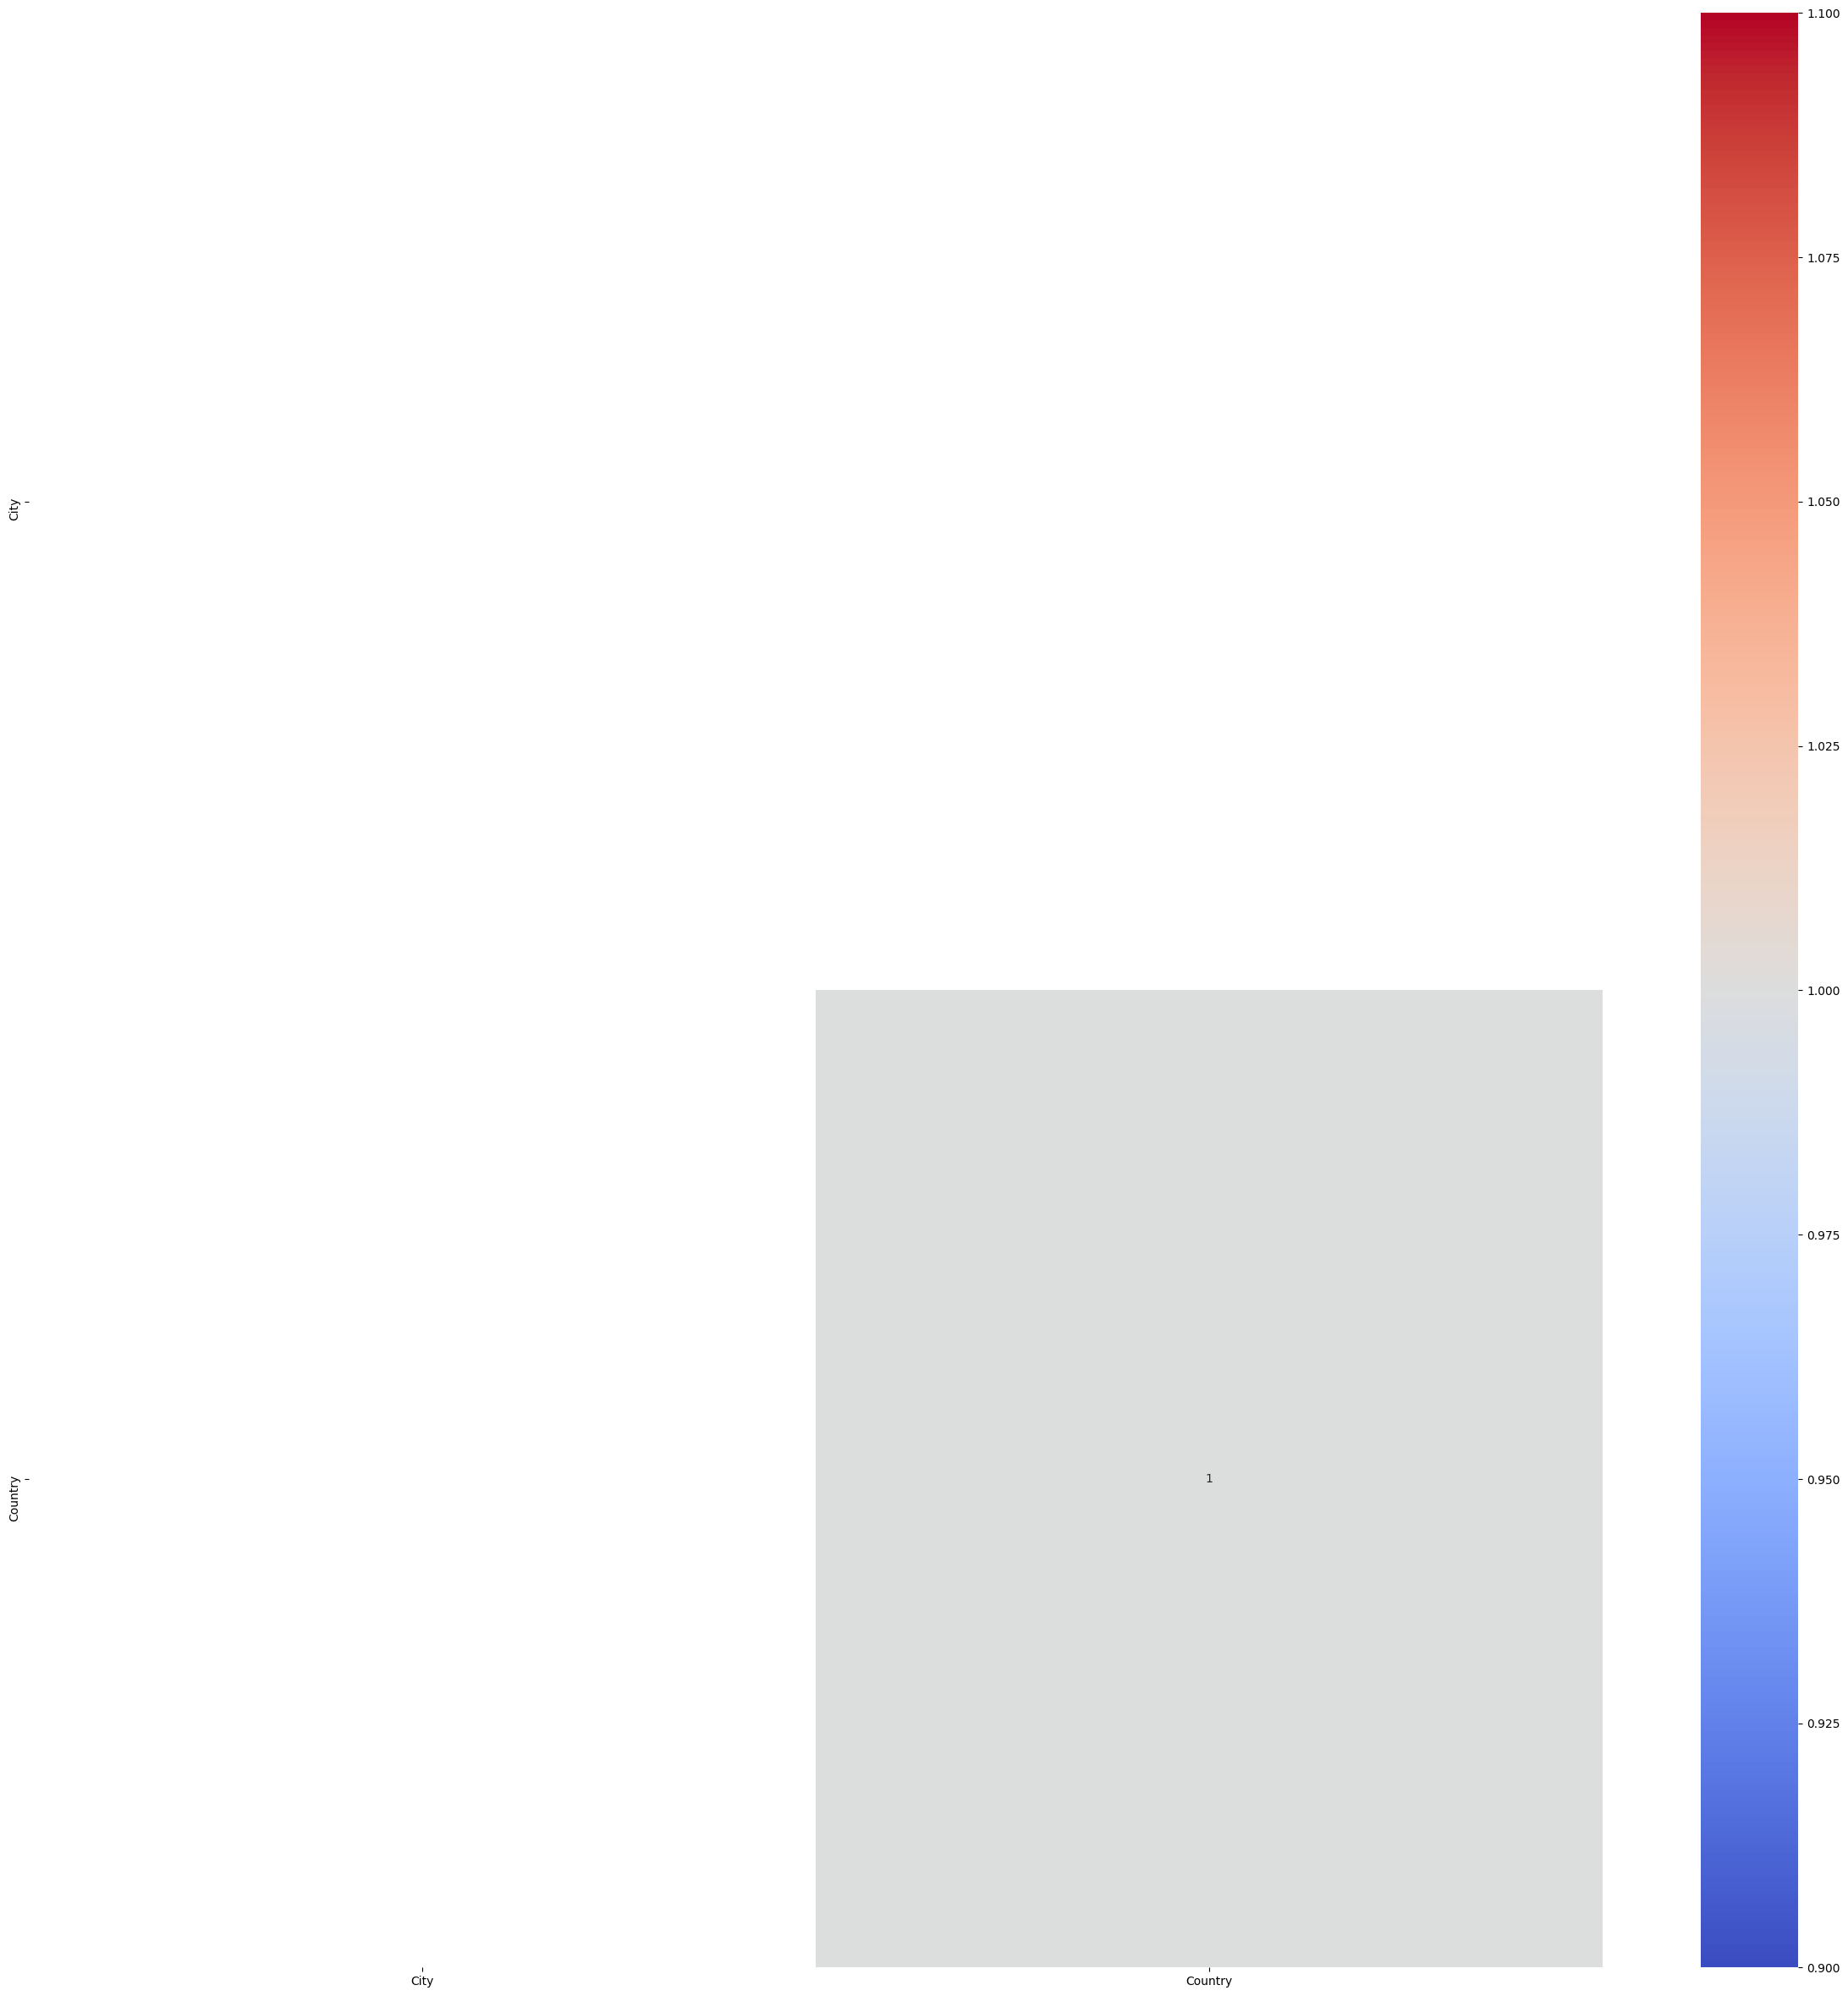

In [12]:
#contingency table for categorical variables
import pandas as pd
from scipy.stats import chi2_contingency

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#pairwise correlation of categorical data
rows= []

for var1 in df_cat:
    col = []
    for var2 in df_cat :
        cramers =cramers_corrected_stat(pd.crosstab(df_cat[var1], df_cat[var2]))
        col.append(round(cramers,2)) # Keeping of to two decimal
    rows.append(col)

cramers_results = np.array(rows)
df_cat_corr = pd.DataFrame(cramers_results, columns = df_cat.columns, index =df_cat.columns)

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_cat_corr), annot = True, cmap = 'coolwarm')



According to the heatmap, the categorical variables does not have significant pairwise correlation.

<Axes: >

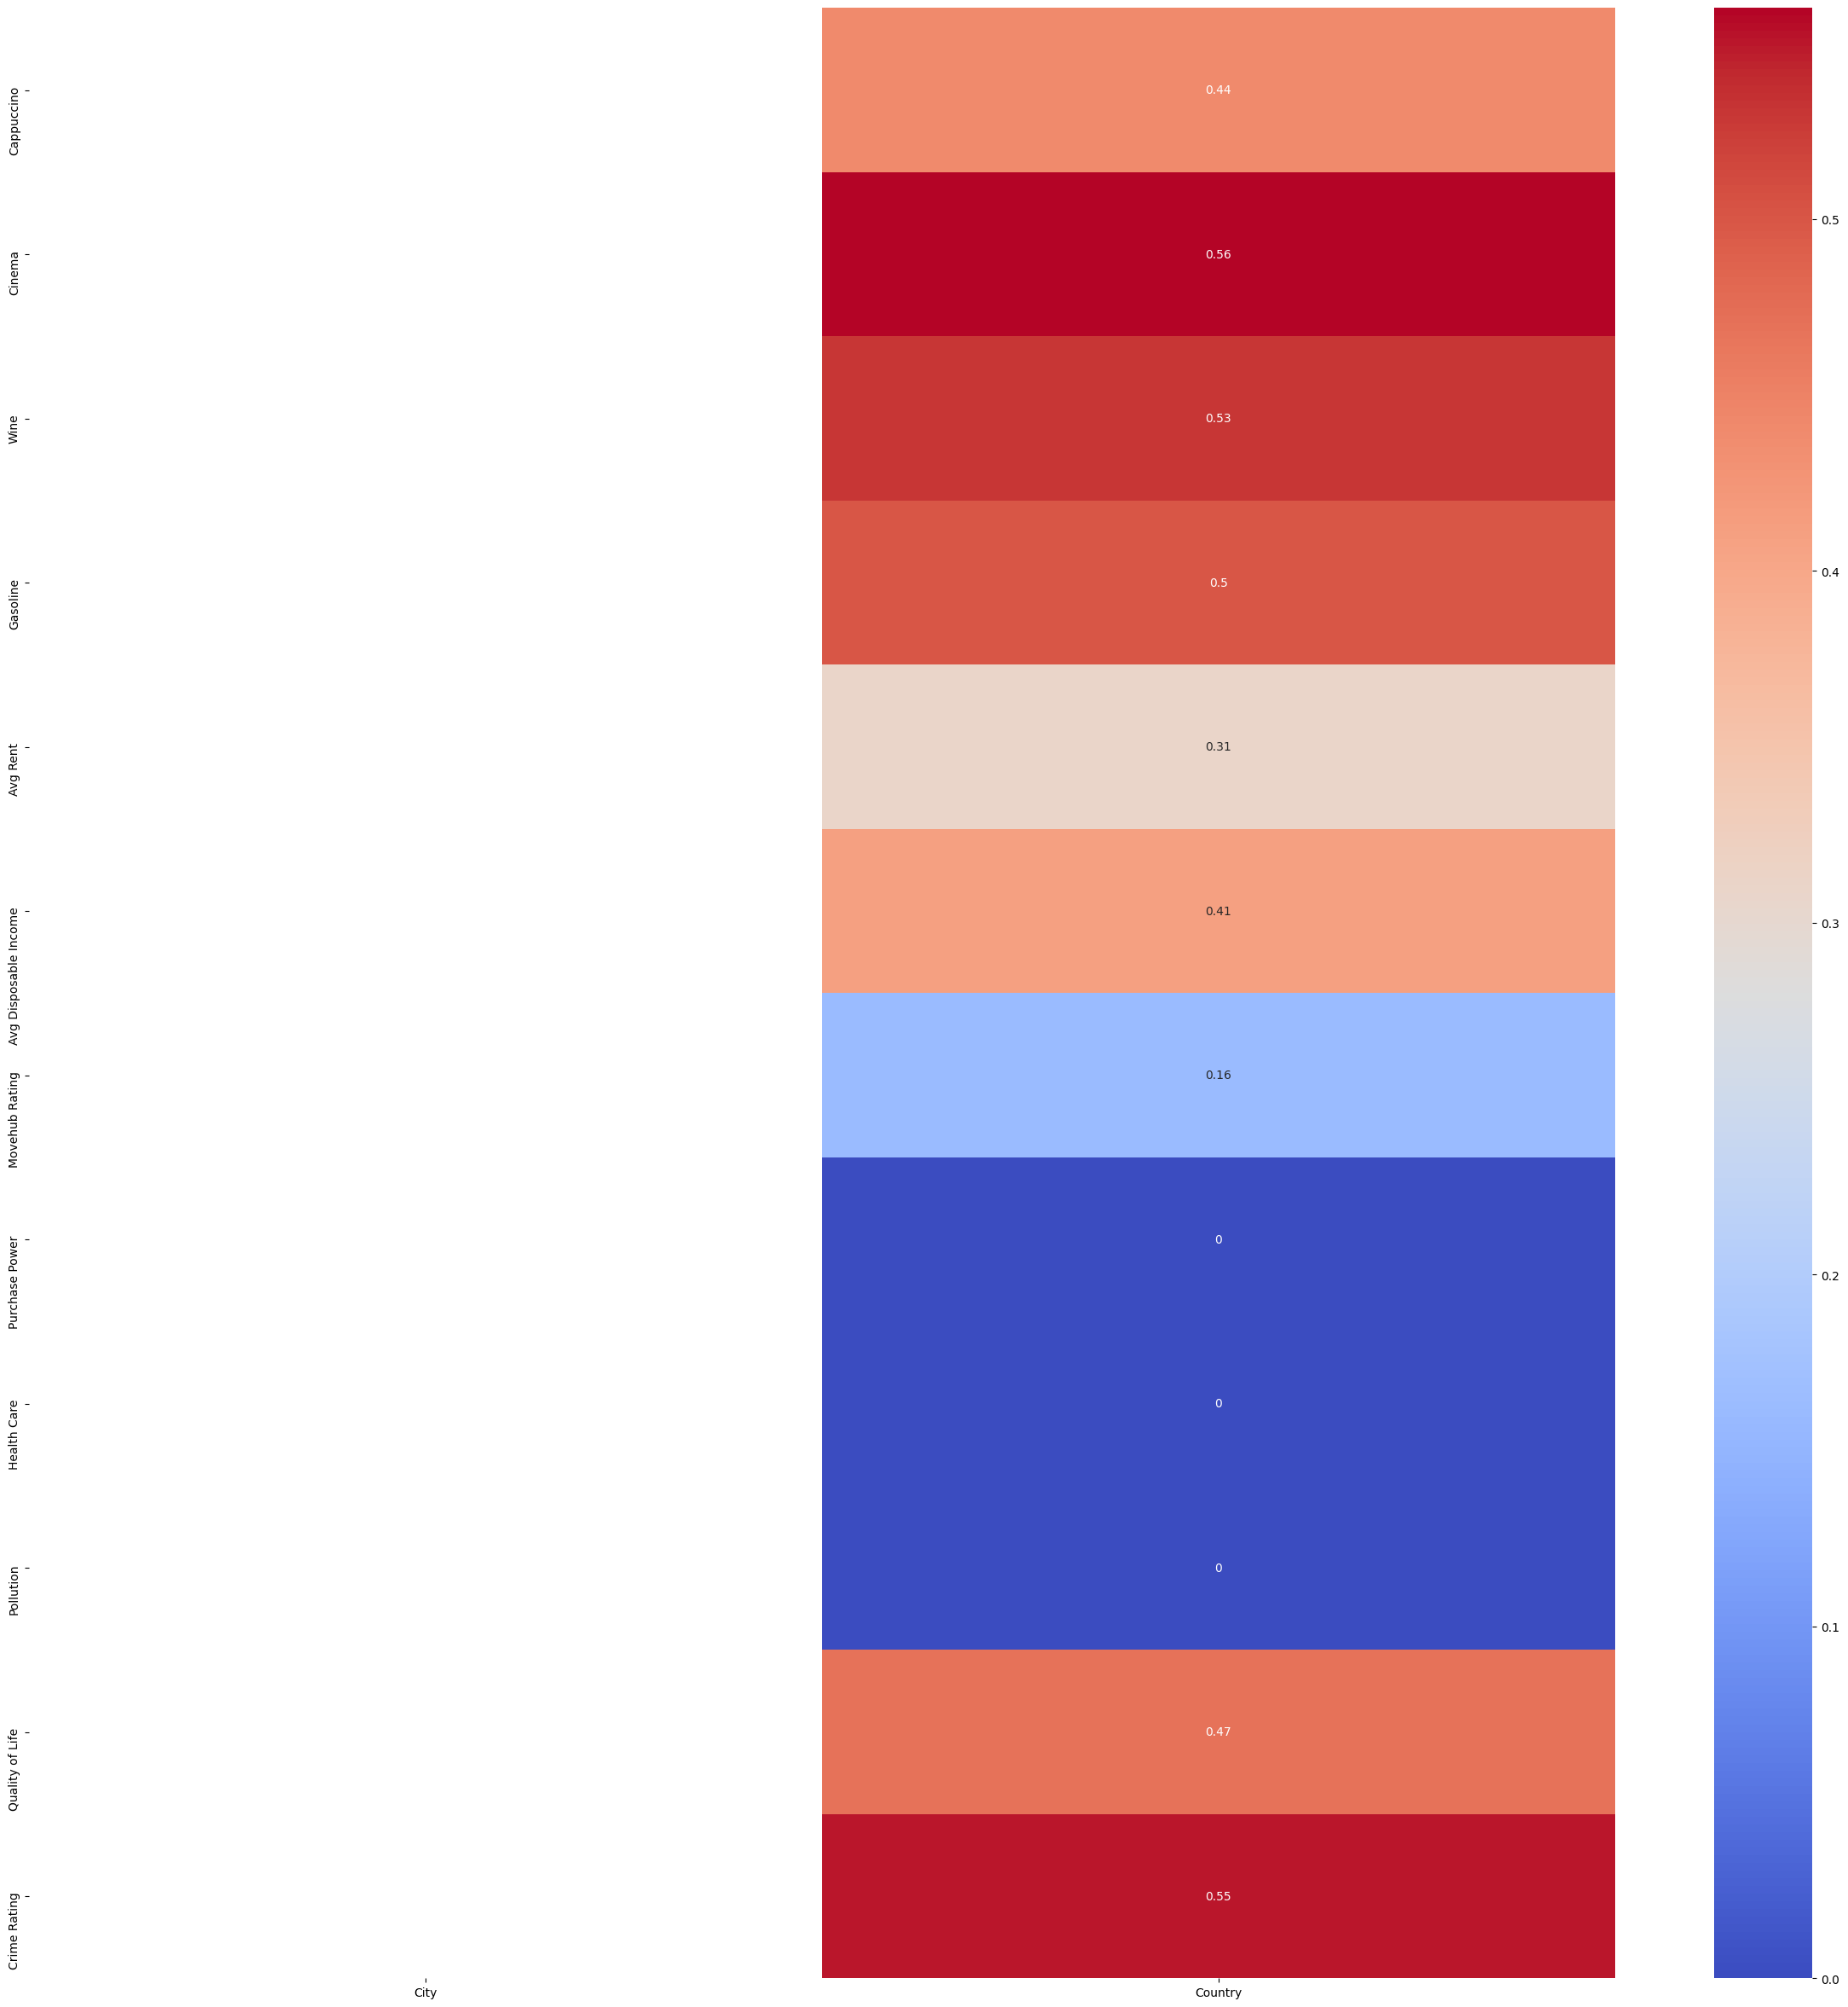

In [13]:
#pairwise relationship between numerical variables and categorical varaiables
rows = []

for var1 in df_num:
    col = []
    for var2 in df_cat :
        cramers =cramers_corrected_stat(pd.crosstab(df_num[var1], df_cat[var2]))
        col.append(round(cramers,2)) # Keeping of to two decimal
    rows.append(col)

cramers_results = np.array(rows)
df_num_cat_corr = pd.DataFrame(cramers_results, columns = df_cat.columns, index =df_num.columns)

#heatmap of the correlation
fig, ax = plt.subplots(figsize = (30, 30))
sns.heatmap(abs(df_num_cat_corr), annot = True, cmap = 'coolwarm')


For numerical and categorical variables, That Country is highly correlated with crime rating, quality of life, income, gasoline, wine, cinema, and cappocino prices. 

## 5. Scaling Decisions

We want to standardize the dataset, since some features have a higher std that can negatively impact the clustering model results. By scaling the data, it would normalize stds to be lower.

In [84]:
from sklearn.preprocessing import StandardScaler

numeric_columns = df_subset_outlier_removal.select_dtypes(include=['number']).columns
categorical_columns = df_subset_outlier_removal.select_dtypes(exclude=['number']).columns

X_numeric = df_subset_outlier_removal[numeric_columns]
X_categorical = df_subset_outlier_removal[categorical_columns]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

X_categorical.reset_index(drop=True, inplace=True)
df_scaled = pd.concat([X_scaled, X_categorical], axis=1)

## 6. Clusterability and Clustering Structure

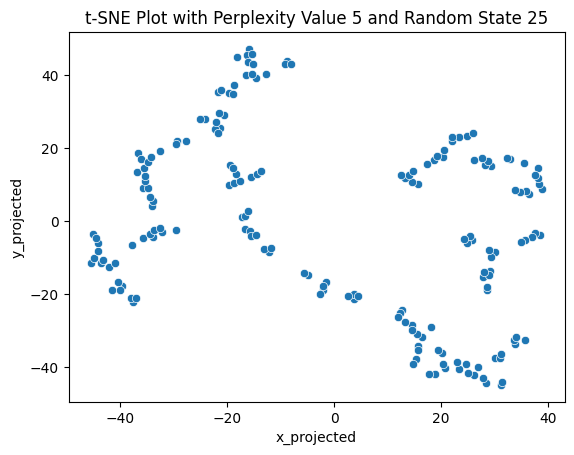

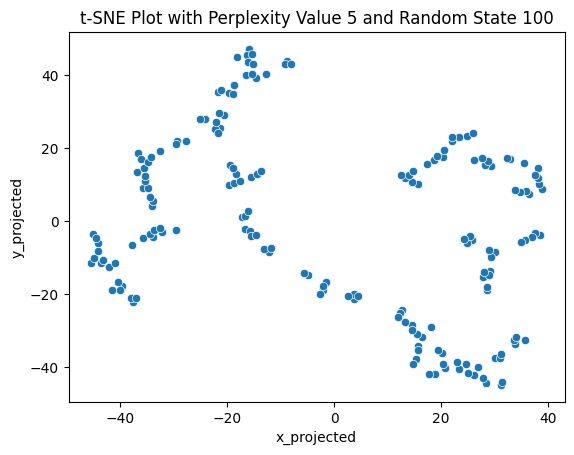

--------------------------------------------


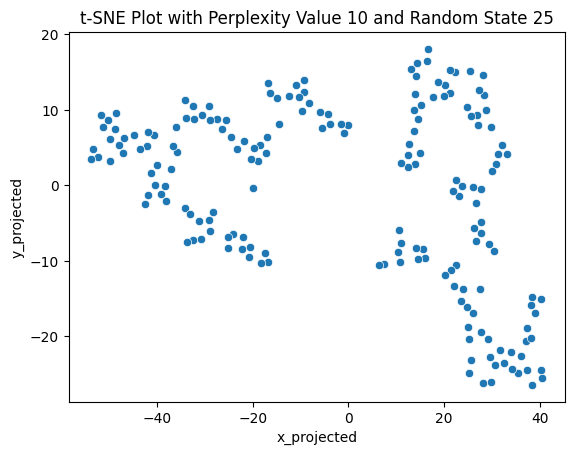

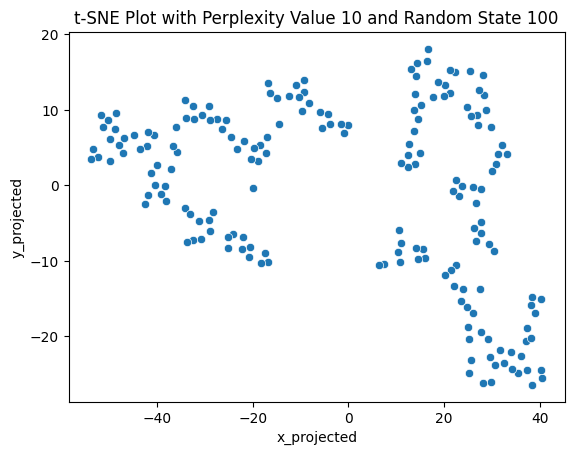

--------------------------------------------


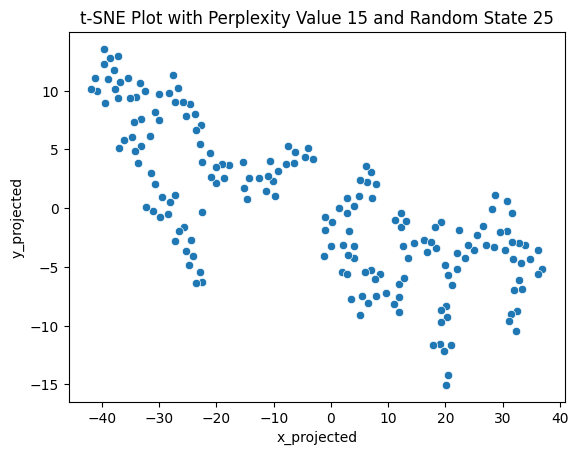

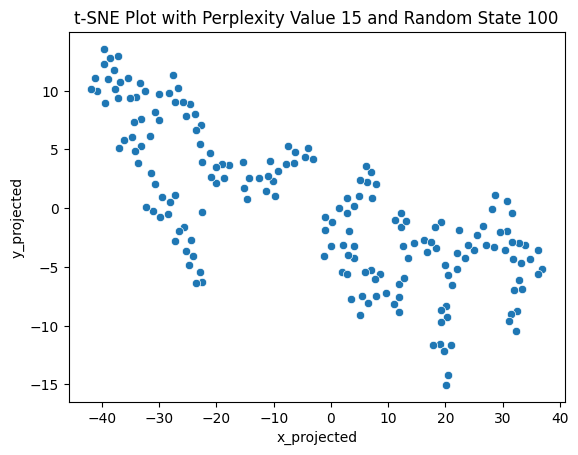

--------------------------------------------


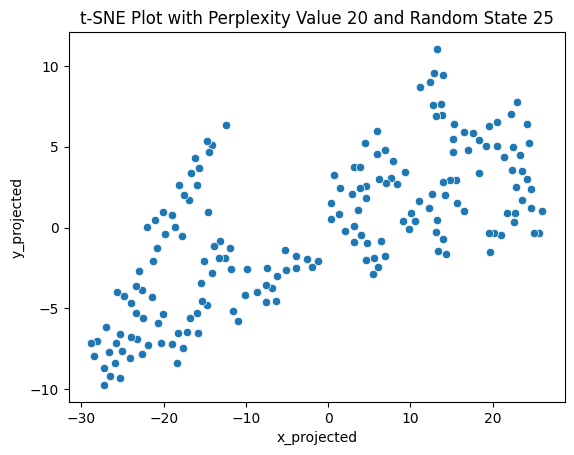

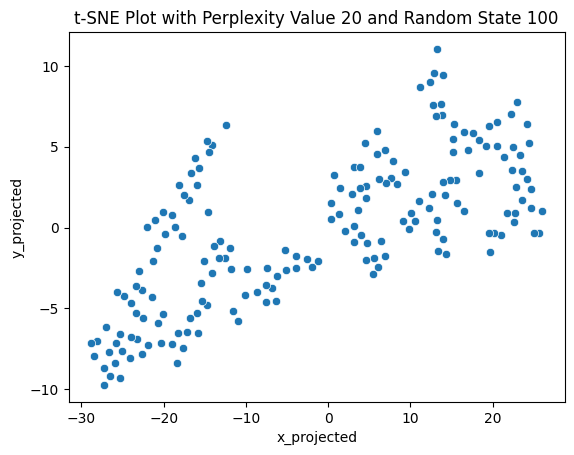

--------------------------------------------


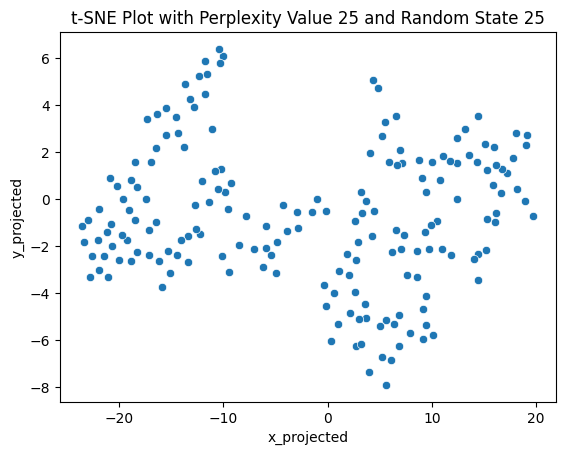

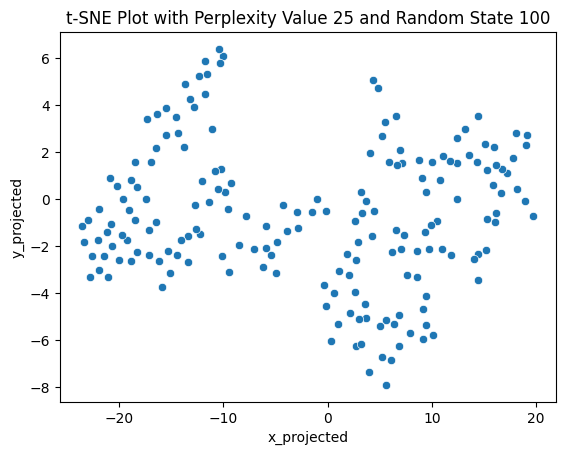

--------------------------------------------


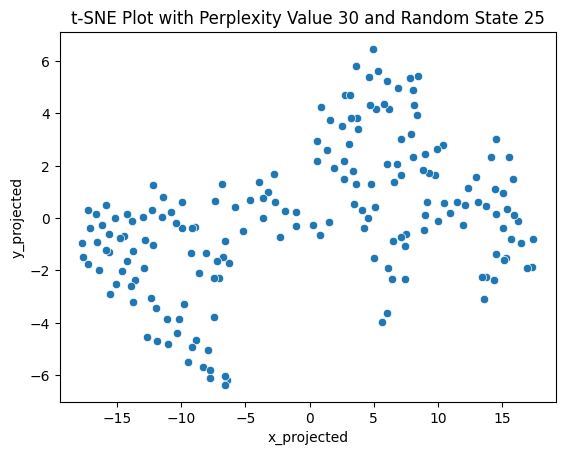

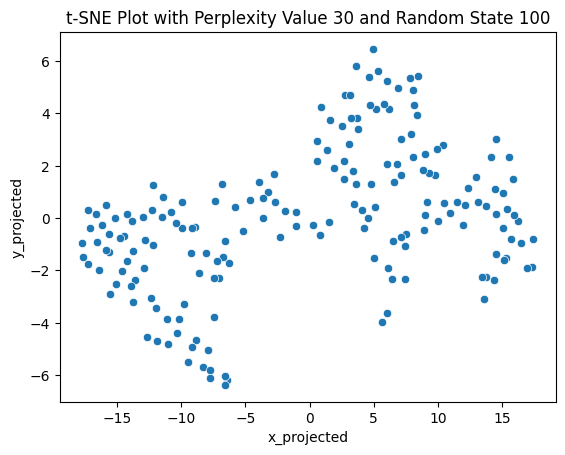

--------------------------------------------


In [15]:
from sklearn.manifold import TSNE
for perp in [5,10, 15, 20, 25, 30]:
    for rs in [25, 100]:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=rs)
        data_tsne = tsne.fit_transform(X_numeric)
        df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
        df_combo = pd.concat([df_scaled, df_tsne], axis=1)
        sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
        plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(perp, rs))
        plt.show()
    print('--------------------------------------------')

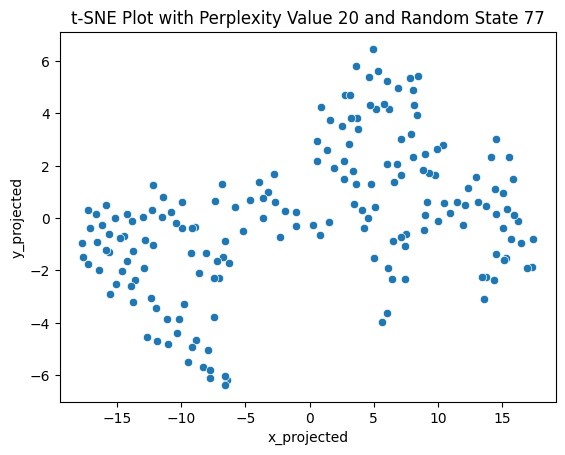

In [16]:
tsne = TSNE(n_components=2, perplexity=30, random_state=100)
data_tsne = tsne.fit_transform(X_numeric)
df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
df_combo = pd.concat([df_subset_outlier_removal, df_tsne], axis=1)
sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)
plt.title('t-SNE Plot with Perplexity Value %s and Random State %s' %(20, 77))
plt.show()

The TSNE plot shows that the dataset is clusterable. We can see seperation of two clusters in the plot.  
The shape of the clusters is elliptical.  
The clusters are balanced in size.  
The clusters are mostly well-seperated, with some random states and perplexity that are not well-seperated.  
There might be nested/sub clusters because there are some points that are not well-seperated.  
[* Is there an association between each of the attributes and the clustering structure suggested by the t- SNE plot? Show the appropriate visualizations to explain.]  
TSNE can help determine the if there exist clustering structure, the cluster shape, the number of clusters, the number of objects in each cluster, whether the clusters are well-separated. However, it cannot determine the distance between objects and clusters in the original data, and the centroid, sparsity, and existence of noise or outliers in the original data.  

## 7. Clustering Algorithm Selection Motivation

k means clustering.

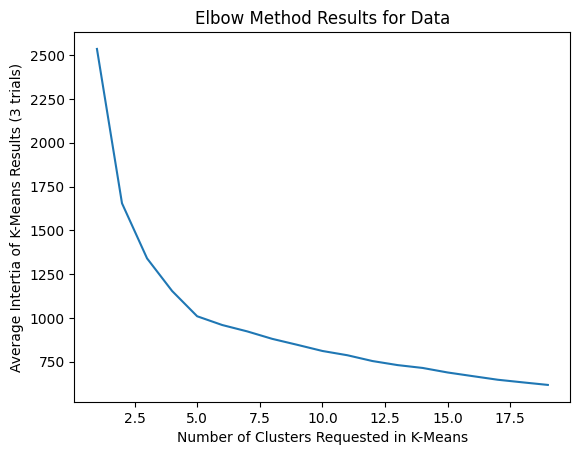

In [22]:
from sklearn.cluster import KMeans

cluster_num_list = range(1,20) 
avg_inertia_list = []
for k in cluster_num_list:
    sub_inertia_list = []
    for i in range(0,3):
        kmeans=KMeans(n_clusters=k).fit(X_scaled)
        sub_inertia_list.append(kmeans.inertia_)
    avg_inertia_list.append(np.average(sub_inertia_list))

plt.plot(cluster_num_list, avg_inertia_list)
plt.xlabel("Number of Clusters Requested in K-Means")
plt.ylabel("Average Intertia of K-Means Results (3 trials)")
plt.title("Elbow Method Results for Data")
plt.show()

5 shows significant evidence for the number of k means clusters

In [85]:
kmean_df = X_scaled
kmean_df['predicted_cluster']=KMeans(n_clusters=5, random_state=100).fit(kmean_df).labels_
print(kmean_df.head())


   Cappuccino    Cinema      Wine  Gasoline  Avg Rent  Avg Disposable Income  \
0    1.547668  2.238629  0.408171  0.889879  1.041162               3.163401   
1    1.087108  2.366539  1.028174  0.774652  2.505949               2.780294   
2    2.008228  1.982808  0.096686  0.688232  0.935131               2.703363   
3    1.179220  1.814698  0.906546 -0.118358  1.646018               2.165405   
4    2.455630  2.023009  1.921097 -1.040176  1.931127               1.869819   

   Movehub Rating  Purchase Power  Health Care  Pollution  Quality of Life  \
0        1.149818        2.219344    -0.008922   1.606172         0.639787   
1        0.556431        0.768894     0.595392  -0.643433         1.070865   
2        0.696494        1.600878     0.920637   0.506692         1.319581   
3        2.380267        0.812580     0.975514  -0.871525         0.703433   
4        0.155820        1.705429    -0.380344  -1.781187         0.968851   

   Crime Rating  predicted_cluster  
0     -0.3834

## 8. Clustering Algorithm Practical Considerations

In [86]:
from kmodes.kprototypes import KPrototypes

#df_no_nans = df_scaled.drop(df_scaled.index[-1])
# drop last n rows
#df_no_nans.head()
#df_no_nans.isna().sum()
df_no_nans = df_scaled.dropna()
kp = KPrototypes(n_clusters=5, random_state=1000)
fit_clusters = kp.fit_predict(df_no_nans, categorical=[12,13])
df_no_nans['predicted_cluster']=fit_clusters


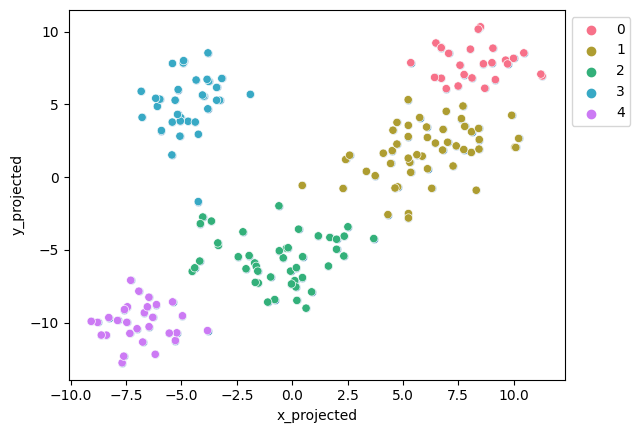

In [87]:
tsne = TSNE(n_components=2, perplexity=30, random_state=25)
data_tsne = tsne.fit_transform(df_no_nans.select_dtypes(include='number'))
df_tsne = pd.DataFrame(data_tsne, columns=['x_projected', 'y_projected'])
df_combo = pd.concat([df_no_nans.select_dtypes(include='number'), df_tsne], axis=1)
sns.scatterplot(x='x_projected',y='y_projected', data=df_combo)


sns.scatterplot(x='x_projected',y='y_projected', hue='predicted_cluster', palette=sns.color_palette("husl", 5), data=df_combo)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## 9. Clustering Algorithm #1



In [27]:
df_subset_outlier_removal.isnull().sum()

City                     0
Country                  0
Cappuccino               0
Cinema                   0
Wine                     0
Gasoline                 0
Avg Rent                 0
Avg Disposable Income    0
Movehub Rating           0
Purchase Power           0
Health Care              0
Pollution                0
Quality of Life          0
Crime Rating             0
dtype: int64

(185, 14)

## 10. Clustering Algorithm #2

## 11. Discussion

## 12. Conclusion

## References